## Ejecutar las simulaciones

In [5]:
schedule_names = ['fcfs', 'easy-backfill', 'sjf']
nombres = ' '.join(schedule_names)

In [6]:
%%bash -s "$nombres"
cd ..
./scripts/run-simulations.sh $1

time="2023-10-08 12:09:39.882" level=info msg="Waiting for valid context" batsim command="batsim -p platforms/small_platform.xml -w workloads/workload.json -e output/fcfs/fcfs" extracted socket endpoint="tcp://localhost:28000" ready timeout (seconds)=10
time="2023-10-08 12:09:39.885" level=info msg="Starting simulation" batsim cmdfile=output/fcfs/fcfs/cmd/batsim.bash batsim command="batsim -p platforms/small_platform.xml -w workloads/workload.json -e output/fcfs/fcfs" batsim logfile=output/fcfs/fcfs/log/batsim.log scheduler cmdfile=output/fcfs/fcfs/cmd/sched.bash scheduler command="python -m pybatsim --options-file configs/fcfs.json schedulers/AllocOnly_sched.py" scheduler logfile (err)=output/fcfs/fcfs/log/sched.err.log scheduler logfile (out)=output/fcfs/fcfs/log/sched.out.log simulation timeout (seconds)=604800
time="2023-10-08 12:10:29.577" level=info msg="Simulation subprocess succeeded" command="batsim -p platforms/small_platform.xml -w workloads/workload.json -e output/fcfs/fcfs

## Imports

In [7]:
from IPython import display

In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import evalys
from evalys.jobset import JobSet

# Obteniendo los archivos a analizar

In [9]:
schedule_files = []
jobs_files = []
for folders in os.listdir('../output/'):
    for files in os.listdir('../output/' + folders):
        if files.endswith('_schedule.csv'):
            schedule_files.append(folders + "/" +  files)
        elif files.endswith('_jobs.csv'):
            jobs_files.append(folders + "/" + files)

schedule_files = [os.path.join('../output', str(file)) for file in sorted(schedule_files)]
jobs_files = [os.path.join('../output', str(file)) for file in sorted(jobs_files)]
print(schedule_files)
print(jobs_files)

['../output/easy-backfill/easy-backfill_schedule.csv', '../output/fcfs/fcfs_schedule.csv', '../output/sjf/sjf_schedule.csv']
['../output/easy-backfill/easy-backfill_jobs.csv', '../output/fcfs/fcfs_jobs.csv', '../output/sjf/sjf_jobs.csv']


In [10]:
metrics = pd.DataFrame()
for file in schedule_files:
    print(file)
    schedule_name = os.path.basename(file).split('_')
    if schedule_name[0] in schedule_names:
        df = pd.read_csv(file)
        df['schedule'] = schedule_name[0]
        metrics = metrics.append(df)
    if schedule_name[1] in schedule_names:
        df = pd.read_csv(file)
        df['schedule'] = schedule_name[1]
        metrics = metrics.append(df)
    print("----")
metrics.set_index('schedule', inplace=True)

../output/easy-backfill/easy-backfill_schedule.csv
----
../output/fcfs/fcfs_schedule.csv
----
../output/sjf/sjf_schedule.csv
----


In [11]:
jobsets = {}
for file in jobs_files:
    schedule_name = os.path.basename(file).split('_')
    if schedule_name[0] in schedule_names:
        print("reading", file)
        jobsets[schedule_name[0]] = JobSet.from_csv(file)
    if schedule_name[1] in schedule_names:
        print("reading", file)
        jobsets[schedule_name[1]] = JobSet.from_csv(file)

reading ../output/easy-backfill/easy-backfill_jobs.csv
reading ../output/fcfs/fcfs_jobs.csv
reading ../output/sjf/sjf_jobs.csv


In [12]:
for schedule in schedule_names:
    print("Schedule", schedule)
    df = jobsets['fcfs'].df
    #print profile and execution_time
    print(df[['profile', 'execution_time']])

Schedule fcfs
     profile  execution_time
0     med_66      638.758249
1      low_6        3.200095
2      low_4        7.747926
3     med_78       62.280330
4     med_75       74.275361
...      ...             ...
1472   low_7       11.409315
1473   low_7       17.951107
1474  med_82      997.256111
1475  low_36       19.811183
1476  med_76      229.159672

[1477 rows x 2 columns]
Schedule easy-backfill
     profile  execution_time
0     med_66      638.758249
1      low_6        3.200095
2      low_4        7.747926
3     med_78       62.280330
4     med_75       74.275361
...      ...             ...
1472   low_7       11.409315
1473   low_7       17.951107
1474  med_82      997.256111
1475  low_36       19.811183
1476  med_76      229.159672

[1477 rows x 2 columns]
Schedule sjf
     profile  execution_time
0     med_66      638.758249
1      low_6        3.200095
2      low_4        7.747926
3     med_78       62.280330
4     med_75       74.275361
...      ...             ...
1

In [13]:
def calculate_compute_utilisation(schedule):
    compute_time = jobsets[schedule].df[['execution_time', 'requested_number_of_resources']].apply(lambda row: row.execution_time * row.requested_number_of_resources, axis=1).sum()
    return compute_time / (metrics.loc[schedule].makespan * 96)

def calculate_storage_utilisation(schedule):
    storage_time = jobsets[schedule].df[['execution_time', 'metadata']].apply(lambda row: row.execution_time * row.metadata, axis=1).sum()
    burst_buffer_capacity = 5 * 10**9
    num_burst_buffers = 12
    total_storage_time = metrics.loc[schedule].makespan * num_burst_buffers * burst_buffer_capacity
    return storage_time / total_storage_time

def create_metric_df(metric):
    return pd.concat([jobsets[schedule].df[metric].rename(schedule) for schedule in schedule_names], axis=1)

In [14]:
def bounded_slowdown(df):
    return (df.turnaround_time / df.execution_time.clip(lower=60)).clip(lower=1)

def create_all_metrics_df():
    dfs = []
    for schedule in schedule_names:
        df = jobsets[schedule].df
        df = df.assign(schedule=schedule).assign(bounded_slowdown=bounded_slowdown(df))[['schedule', 'waiting_time', 'turnaround_time', 'stretch']]
        dfs.append(df)
    df = pd.concat(dfs, axis=0).rename({'stretch': 'slowdown'}, axis=1)
    return df

In [15]:
metrics['compute_utilisation'] = pd.Series({schedule: calculate_compute_utilisation(schedule) for schedule in schedule_names})
metrics['storage_utilisation'] = pd.Series({schedule: calculate_storage_utilisation(schedule) for schedule in schedule_names})

In [16]:
metrics = metrics.reindex(schedule_names)
metrics.index.rename(None, inplace=True)
# sns.set_theme(context='talk', style='whitegrid')
sns.set_theme(style='whitegrid')

In [17]:
metrics.T

,fcfs,easy-backfill,sjf
batsim_version,4.0.0,4.0.0,4.0.0
consumed_joules,0,0,0
makespan,261886,261997,261886
max_slowdown,10769.2,7796.38,10769.2
max_turnaround_time,11526.8,11586.7,11526.8
max_waiting_time,11515.5,11577.9,11515.5
mean_slowdown,231.944,131.362,231.944
mean_turnaround_time,1861.18,1246.01,1861.18
mean_waiting_time,1684.32,1068.76,1684.32
nb_computing_machines,4,4,4


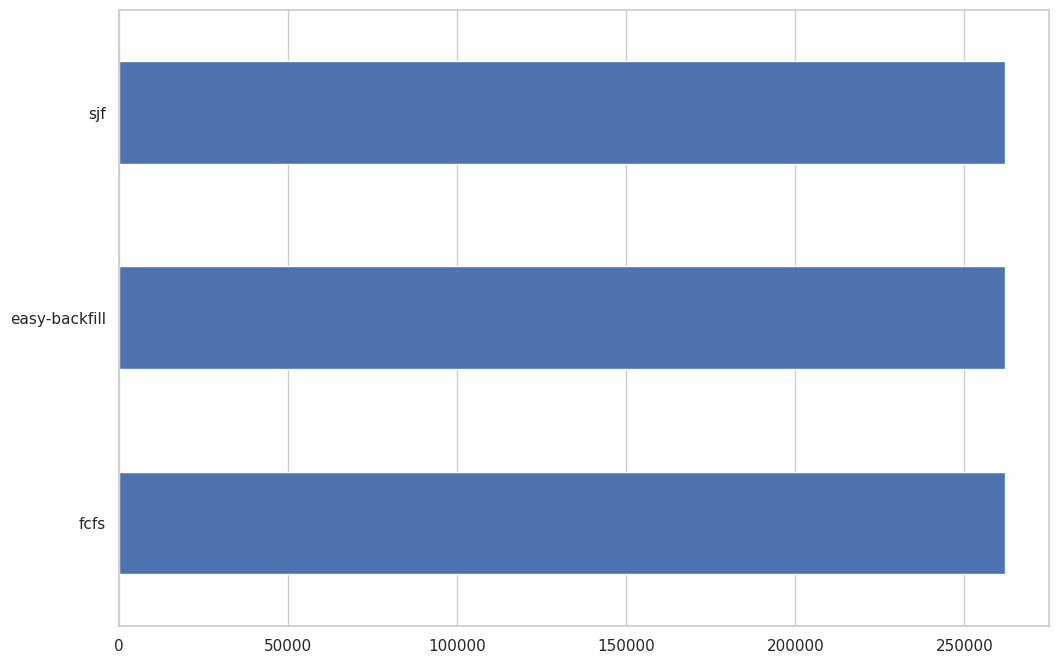

In [18]:
ax = metrics['makespan'].plot.barh(figsize=(12, 8))
ax.grid(axis='y')

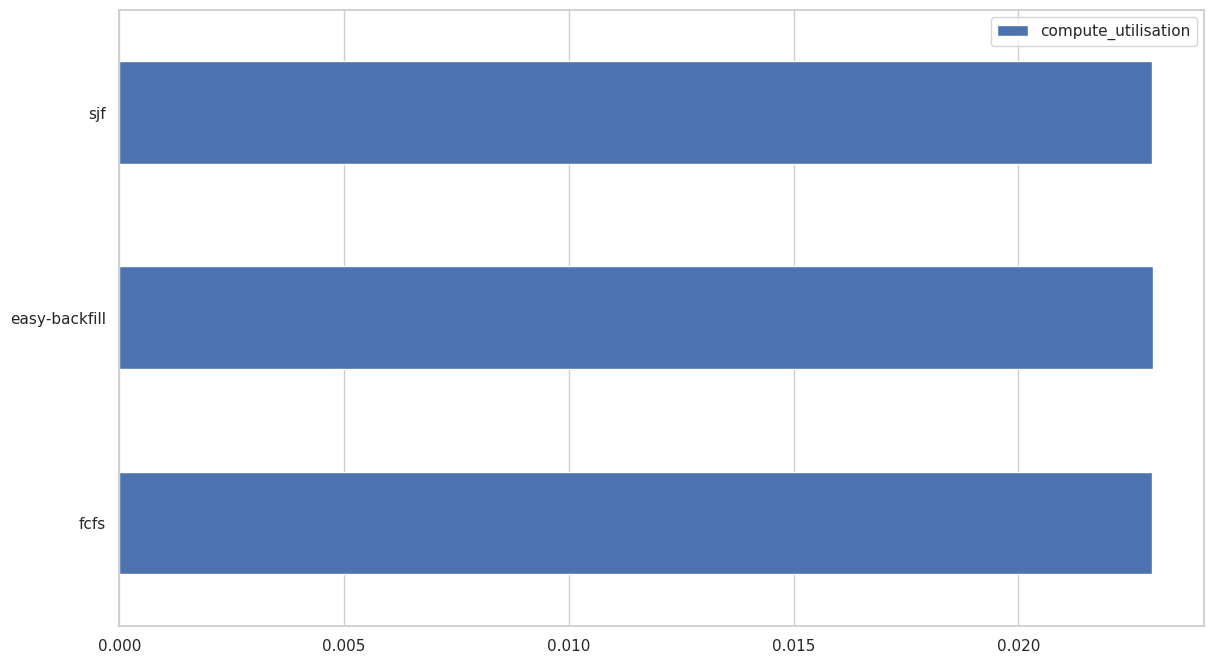

In [19]:
ax = metrics[['compute_utilisation']].plot.barh(figsize=(14, 8))
ax.grid(axis='y')

In [20]:
metrics_df = create_all_metrics_df()
metrics_df

,schedule,waiting_time,turnaround_time,slowdown
0,fcfs,0.000030,638.758279,1.000000
1,fcfs,638.760250,641.960345,200.606659
2,fcfs,641.962315,649.710241,83.856021
3,fcfs,638.760265,701.040595,11.256212
4,fcfs,649.712212,723.987573,9.747345
...,...,...,...,...
1472,sjf,5029.281079,5040.690394,441.804835
1473,sjf,2509.281064,2527.232171,140.784197
1474,sjf,1740.225903,2737.482014,2.745014
1475,sjf,2737.483984,2757.295168,139.178721


In [21]:
waiting_times = create_metric_df('waiting_time')
waiting_times.describe()

,fcfs,easy-backfill,sjf
count,1477.000000,1477.000000,1477.000000
mean,1684.320909,1068.758055,1684.320909
std,1927.687951,1574.262590,1927.687951
min,0.000030,0.000030,0.000030
25%,70.052134,19.813199,70.052134
50%,1026.011698,192.380675,1026.011698
75%,2656.873727,1646.452171,2656.873727
max,11515.498785,11577.906208,11515.498785


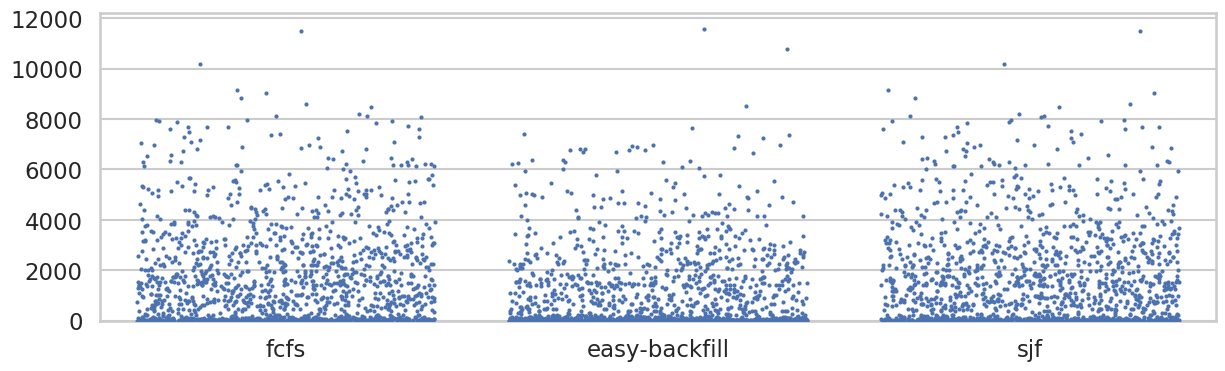

In [22]:
largest = pd.concat([metrics_df[metrics_df.schedule == schedule][['schedule', 'waiting_time']].nlargest(n=4000, columns='waiting_time') for schedule in schedule_names])
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(14.4,4))
    sns.stripplot(data=largest, x='schedule', y='waiting_time', ax=ax, size=3, jitter=0.4)
    ax.set_ylim(0)
    ax.set_ylabel('')
    ax.set_xlabel('')
fig.savefig('results/waiting-time_dist.pdf', bbox_inches='tight')

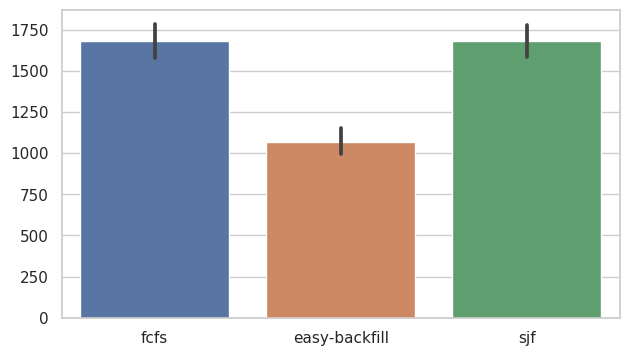

In [23]:
fig, ax = plt.subplots(figsize=(7.2,4))
sns.barplot(data=waiting_times, ax=ax)
fig.savefig('results/waiting-time_mean.pdf', bbox_inches='tight')

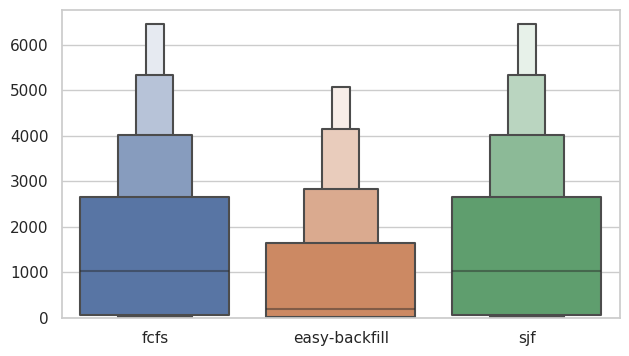

In [24]:
fig, ax = plt.subplots(figsize=(7.2,4))
sns.boxenplot(data=waiting_times, k_depth=4, showfliers=False, ax=ax)
ax.set_ylim(0)
# ax.set_ylim(top=140000)
fig.savefig('results/waiting-time_boxen.pdf', bbox_inches='tight')

In [25]:
turnaround_times = create_metric_df('turnaround_time')
turnaround_times.describe()

,fcfs,easy-backfill,sjf
count,1477.000000,1477.000000,1477.000000
mean,1861.184216,1246.013975,1861.184216
std,1972.999492,1674.629864,1972.999492
min,0.491781,0.491781,0.491781
25%,133.750029,51.385638,133.750029
50%,1337.629365,403.953632,1337.629365
75%,2910.275075,1975.001839,2910.275075
max,11526.787760,11586.660223,11526.787760


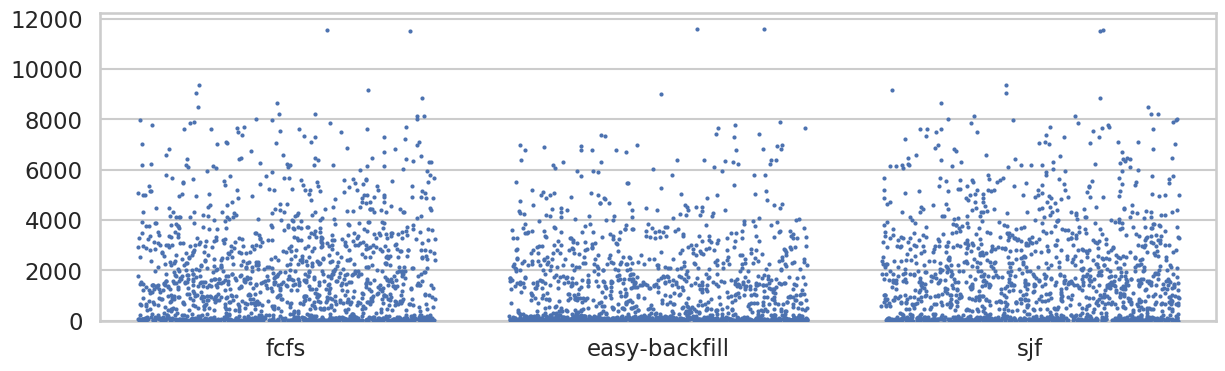

In [26]:
largest = pd.concat([metrics_df[metrics_df.schedule == schedule][['schedule', 'turnaround_time']].nlargest(n=4000, columns='turnaround_time') for schedule in schedule_names])
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(14.4,4))
    sns.stripplot(data=largest, x='schedule', y='turnaround_time', ax=ax, size=3, jitter=0.4)
    ax.set_ylim(0)
#     ax.set_ylim(top=2.5*10**6)
    ax.set_ylabel('')
    ax.set_xlabel('')
fig.savefig('results/turnaround-time_dist.pdf', bbox_inches='tight')

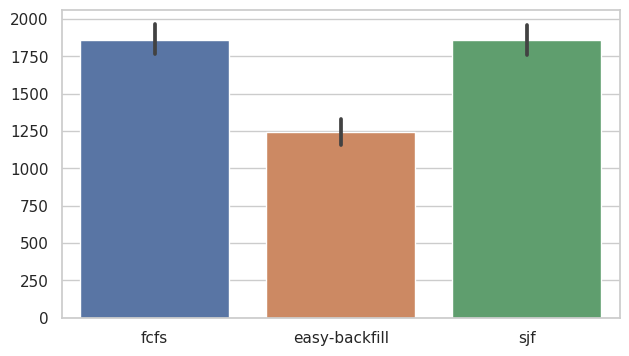

In [27]:
fig, ax = plt.subplots(figsize=(7.2,4))
sns.barplot(data=turnaround_times, ax=ax)
fig.savefig('results/turnaround-time_mean.pdf', bbox_inches='tight')

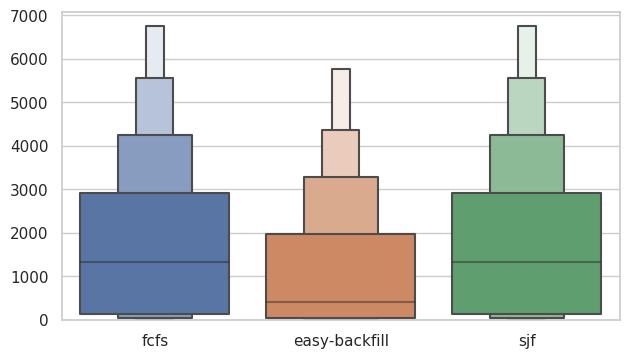

In [28]:
fig, ax = plt.subplots(figsize=(7.2,4))
sns.boxenplot(data=turnaround_times, k_depth=4, showfliers=False, ax=ax)
ax.set_ylim(0)
# ax.set_ylim(top=140000)
fig.savefig('results/turnaround-time_boxen.pdf', bbox_inches='tight')

In [29]:
slowdown = create_metric_df('stretch')
slowdown.describe()

,fcfs,easy-backfill,sjf
count,1477.000000,1477.000000,1477.000000
mean,231.943812,131.362149,231.943812
std,748.474263,511.475426,748.474263
min,1.000000,1.000000,1.000000
25%,2.752103,1.785490,2.752103
50%,27.855889,6.681767,27.855889
75%,188.802771,76.791996,188.802771
max,10769.153397,7796.377769,10769.153397


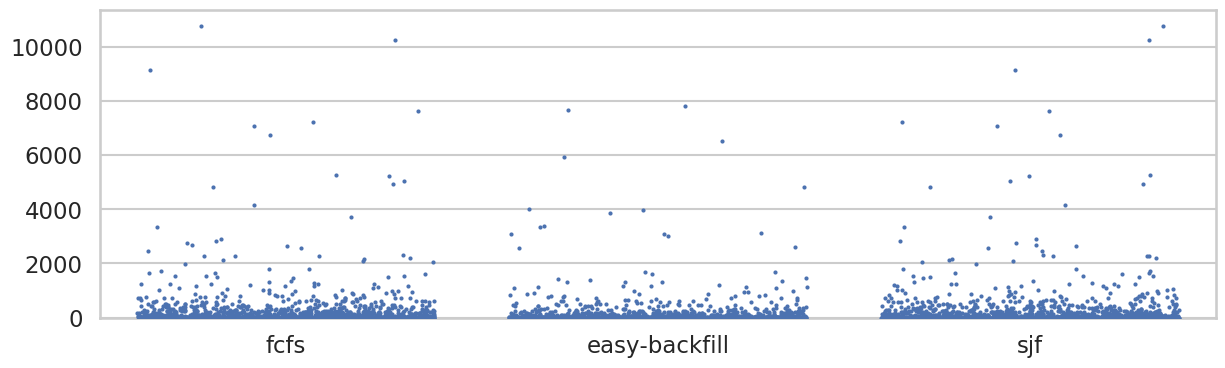

In [30]:
# Scatterplot, outliers
largest = pd.concat([metrics_df[metrics_df.schedule == schedule][['schedule', 'slowdown']].nlargest(n=4000, columns='slowdown') for schedule in schedule_names])
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(14.4,4))
    sns.stripplot(data=largest, x='schedule', y='slowdown', ax=ax, size=3, jitter=0.4)
    ax.set_ylim(0)
    ax.set_ylabel('')
    ax.set_xlabel('')
fig.savefig('results/slowdown_dist.pdf', bbox_inches='tight')

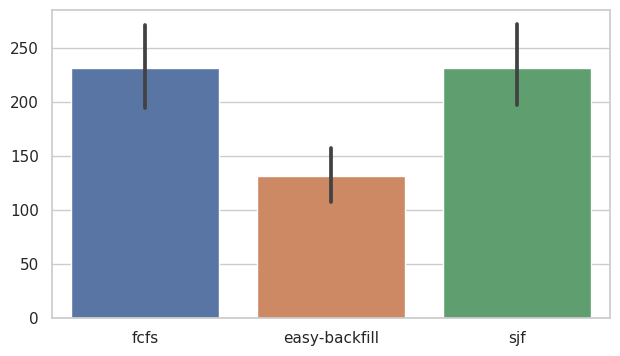

In [31]:
# Mean, logscale
fig, ax = plt.subplots(figsize=(7.2,4))
sns.barplot(data=slowdown, ax=ax)
fig.savefig('results/slowdown_mean.pdf', bbox_inches='tight')

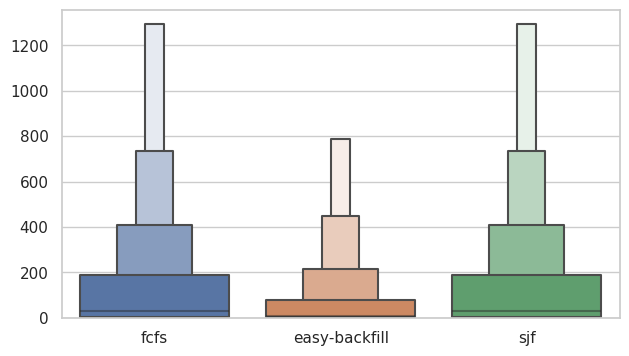

In [32]:
fig, ax = plt.subplots(figsize=(7.2,4))
sns.boxenplot(data=slowdown, k_depth=4, showfliers=False, ax=ax)
ax.set_ylim(0)
# ax.set_ylim(top=140000)
fig.savefig('results/slowdown_boxen.pdf', bbox_inches='tight')

In [33]:
# FCFS

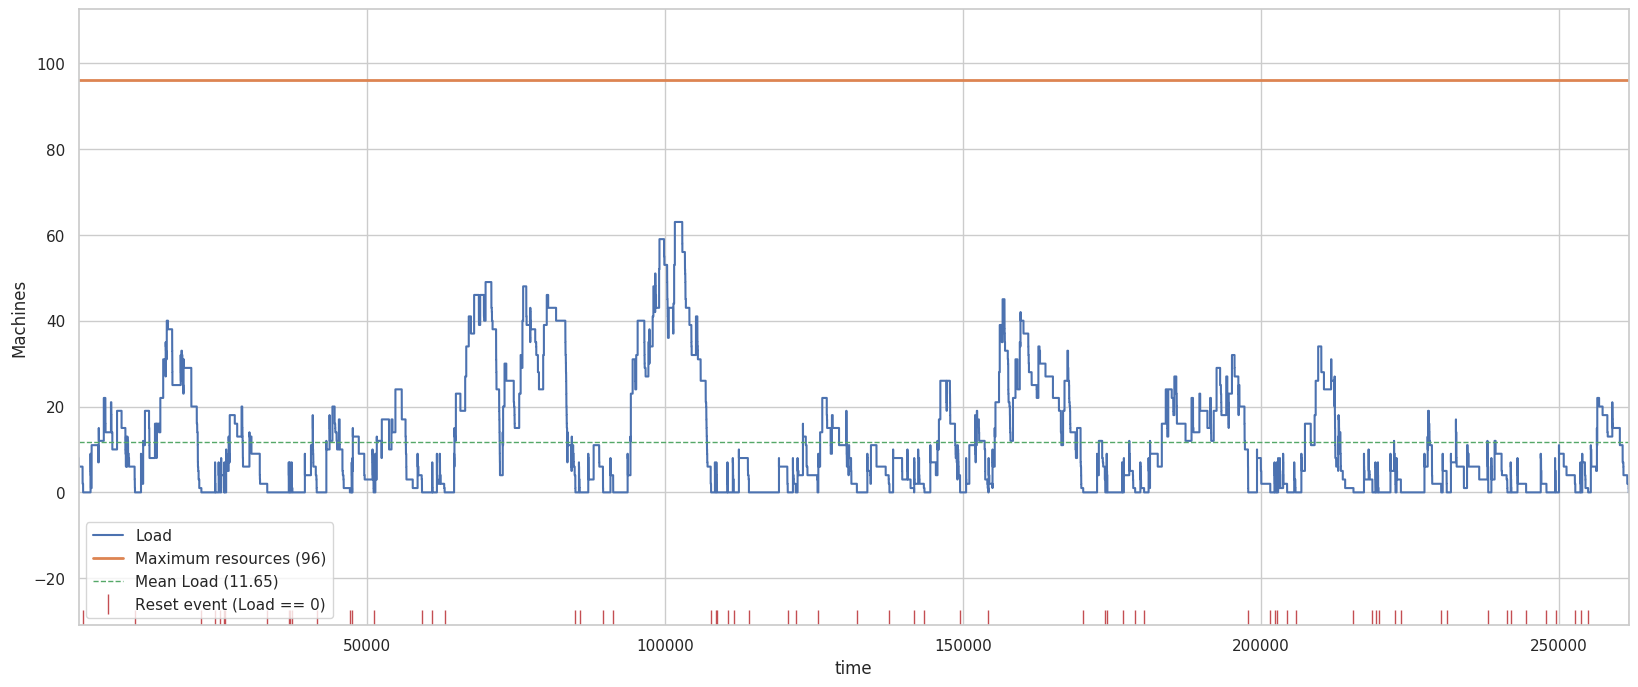

In [34]:
fig, ax = plt.subplots(figsize=(20,8))
evalys.visu.legacy.plot_load(jobsets['fcfs'].queue, nb_resources=96, ax=ax)

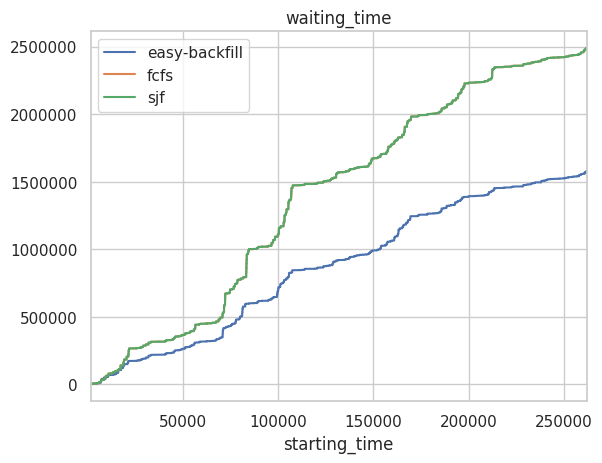

In [35]:
evalys.visu.legacy.plot_series('waiting_time', jobsets)